  # Выпускной проект: Телекоммуникации


# Описание и цель проекта 

В финальном проекте была поставлена задача прогнозирования оттока клиентов из сети "ниединногоразрыва.ком". Целью проекта является построение модели машинного обучения для решения задачи бинарной классификации, где к первой группе людей будут относиться люди, которые хотят разорвать контракт с сетью магазинов, а во второй группе -- клиенты, которые планируют продолжать пользоваться услугами компании. Для дальнейшей работы будут использованы три модели машинного обучения для решения поставленной задачи.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

!pip install phik
import phik

from catboost import CatBoostClassifier

RANDOM_STATE = 140823

Импортируем нужные для анализа библиотеки

In [2]:
df1 = pd.read_csv('/datasets/contract_new.csv')
df2 = pd.read_csv('/datasets/personal_new.csv')
df3 = pd.read_csv('/datasets/internet_new.csv')
df4 = pd.read_csv('/datasets/phone_new.csv')

Прочитаем содержание файлов и приступим к анализу и предобработке

# Выгрузка и анализ данных

## Первый датасет

In [3]:
df1.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [4]:
df1 = df1.rename(columns={'customerID': 'customer_id',
                          'BeginDate': 'begin_date', 
                          'EndDate': 'end_date', 
                          'Type': 'type', 
                          'PaperlessBilling': 'paperless_billing', 
                          'PaymentMethod': 'payment_method', 
                          'MonthlyCharges': 'monthly_charges', 
                          'TotalCharges': 'total_charges'})

Переименуем названия столбцов для удобного обрщения в будущем

In [5]:
df1.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
df1.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64

После вывода информации о датафрейме можно сделать вывод, что в нем нет пропусков

In [7]:
df1['begin_date'] = pd.to_datetime(df1['begin_date'])

df1['total_charges'] = df1['total_charges'].replace(' ', 0)

Можно заметить, что в столбце total_charges вместо нулей стоит пропуск, который не относится к NaN, поэтому его надо заменить на 0 и преобразовать столбец в вещественные числа:

In [8]:
df1['total_charges'] = df1['total_charges'].astype('float')

## Второй датасет

In [9]:
df2.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [10]:
df2 = df2.rename(columns={'customerID': 'customer_id', 
                          'SeniorCitizen': 'senior_citizen', 
                          'Partner':'partner',
                          'Dependents': 'dependents'})

Переименуем столбцы

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [12]:
df2.isna().sum()

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

Во втором датасете также нет пропусков

In [13]:
df2['senior_citizen'] = df2['senior_citizen'].astype('object')

Поменяем формат столбца senior_citizen к типу object

## Третий датасет

In [14]:
df3.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [15]:
df3 = df3.rename(columns={'customerID': 'customer_id',
                          'InternetService': 'internet_service', 
                          'OnlineSecurity': 'online_security',
                          'OnlineBackup': 'online_backup', 
                          'DeviceProtection': 'device_protection',
                          'TechSupport': 'tech_support', 
                          'StreamingTV': 'streaming_tv', 
                          'StreamingMovies': 'streaming_movies'})

Также переименуем столбцы для соответствия стандартам

In [16]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [17]:
df3.isna().sum()

customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

Text(0.5, 1.0, 'Демонстрация дисбаланса классов')

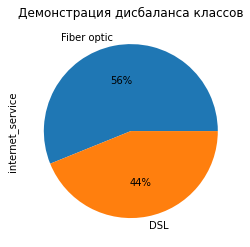

In [18]:
df3['internet_service'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Демонстрация дисбаланса классов')

После вывода графика можно заметить, что графики отличаются на 12 процентных пунктов, что говорит о незначительном дисбалансе

## Четвертый датасет

In [19]:
df4.head(5)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [20]:
df4.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [21]:
df4.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

В 4 датафрейме также нет пропусков

In [22]:
df4 = df4.rename(columns={'customerID': 'customer_id',
                          'MultipleLines': 'multiple_lines'})

Text(0.5, 1.0, 'Демонстрация дисбаланса классов')

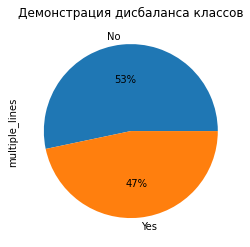

In [23]:
df4['multiple_lines'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Демонстрация дисбаланса классов')

Разница между классами составляет 6 процентных пунктов, что говорит о том, что дисбаланс классов не серьезен

In [24]:
print('Датафрейм 1:', df1.shape)
print('Датафрейм 2:', df2.shape)
print('Датафрейм 3:', df3.shape)
print('Датафрейм 4:', df4.shape)

Датафрейм 1: (7043, 8)
Датафрейм 2: (7043, 5)
Датафрейм 3: (5517, 8)
Датафрейм 4: (6361, 2)


## План работы

    
**1) Описание проекта**
    
__2) Выгрузка и анализ данных__
    
- 2.1) Анализ датасетов отдельно друг от друга
    
- 2.2) Анализ типов переменных
    
- 2.3) Приведение названий столбцов к формату PEP-8
    
- 2.4) Изменение типов переменных там, где это нужно для удобства в дальнейшем исследовании
    
- 2.5) Формулировка выводов и вопросов по второй части проекта
    
**3) Создание моделей для прогнозирования**
    
- 3.1) Выбор целевой переменной и матрицы признаков
    
- 3.2) Разделение на тренировочную и тестовую выборки
    
- 3.3) Кодирование категориальных переменных
    
- 3.4) Создание переменной для категориальных переменных для модели CatBoost
    
- 3.5.1) Подбор оптимальных гиперпараметров для **логистической регресии**, ее обучение
    
- 3.5.2) Анализ показателей целевой метрики ROC-AUC для первой модели, а также построение кривой
    
- 3.6.1) Подбор оптимальных гиперпараметров для **CatBoost**, ее обучение
    
- 3.6.2) Анализ показателей целевой метрики для второй модели, а также построение кривой ROC-AUC
    
- 3.7.1) Подбор оптимальных гиперпараметров для **случайного леса**, обучение модели
    
- 3.7.2) Анализ показателей метрики и построение кривой ROC-AUC
    
- 3.8) Выбор лучшей модели по целевой метрике
    
- 3.9) Тестирование лучшей модели на тестовой выборке и построение матрицы ошибок
    
**4) Написание вывода и отчета по проекту**

# Создание моделей для прогнозирования

## Объединение датафреймов и кодировка 

In [25]:
df_merged = pd.merge(df1, df2, on='customer_id', how='left')
df_merged = pd.merge(df_merged, df3, on='customer_id', how='left') 
df = pd.merge(df_merged, df4, on='customer_id', how='left')
df.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


Объединим датасеты для удобной работы

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [27]:
df['begin_date'].max()

Timestamp('2020-02-01 00:00:00')

Дата выгрузки датасета это 2020-02-01

<AxesSubplot:ylabel='exit'>

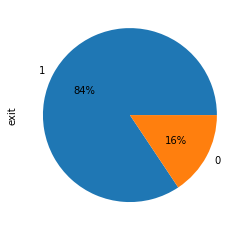

In [28]:
df.loc[df['end_date'] != 'No', 'exit'] = 0
df.loc[df['end_date'] == 'No', 'exit'] = 1
df['exit'] = df['exit'].astype('int')

df['exit'].value_counts().plot(kind='pie', autopct='%1.0f%%')

Создадим целевую переменную и оценим дисбаланс классов в ней

In [29]:
df['end_date'] = pd.to_datetime(df['end_date'].replace('No', df['begin_date'].max()))

Заменим значение No в end_date, чтобы посчитать количество дней, которое клиент пользуется услугами компании и преобразуем в формат datetime

In [30]:
df['delta'] = (df['end_date'] - df['begin_date']).dt.days
df['delta'].head(5)

0      31
1    1036
2     123
3    1371
4     153
Name: delta, dtype: int64

Создадим новый признак для лучшего обучения модели

In [31]:
df.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
exit                    0
delta                   0
dtype: int64

После объединения можно заметить, что в данных присутствуют пропуски

In [32]:
df['internet_service'] = df['internet_service'].fillna('no_internet') 
df['online_security'] = df['online_security'].fillna('no_seciruty')
df['online_backup'] = df['online_backup'].fillna('no_backup')
df['device_protection'] = df['device_protection'].fillna('no_device_protection') 
df['tech_support'] = df['tech_support'].fillna('no_tech_support') 
df['streaming_tv'] = df['streaming_tv'].fillna('no_streaming_tv') 
df['streaming_movies'] = df['streaming_movies'].fillna('no_streaming_movies') 
df['multiple_lines'] = df['multiple_lines'].fillna('unknown')

In [33]:
df.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
exit                 0
delta                0
dtype: int64

In [34]:
#Код ревьюера
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

Пропуски заполнены

## EDA

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


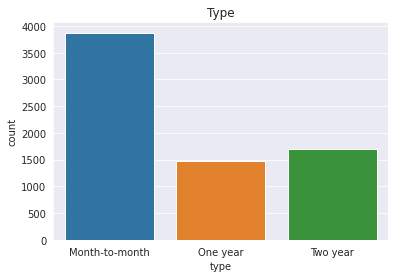

In [35]:
sns.set_style('darkgrid')
ax = sns.countplot(df['type'])
ax.set_title('Type') 

None

Чаще всего встречается тип Month-to-month

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


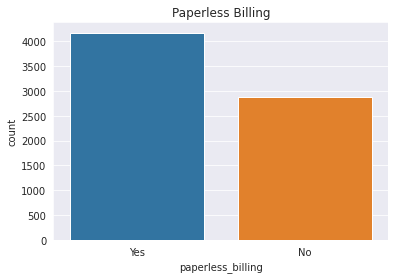

In [36]:
sns.set_style('darkgrid')
ax = sns.countplot(df['paperless_billing'])
ax.set_title('Paperless Billing') 
None

С разницей в 1500 клиенты предпочитают получать бумажный чек

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


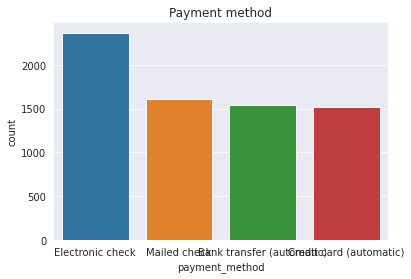

In [37]:
sns.set_style('darkgrid')
ax = sns.countplot(df['payment_method'])
ax.set_title('Payment method') 
None

Также клиенты магазина чаще всего платят онлайн, на втором вместе платежи наличными

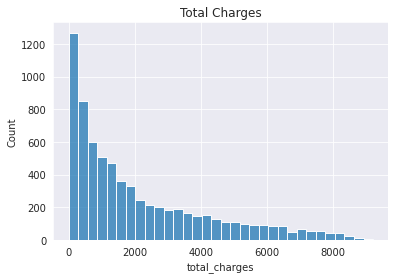

In [38]:
ax = sns.histplot(df['total_charges'])
ax.set_title('Total Charges') 
None

В среднем клиенты платят примерно 1000 у.е.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


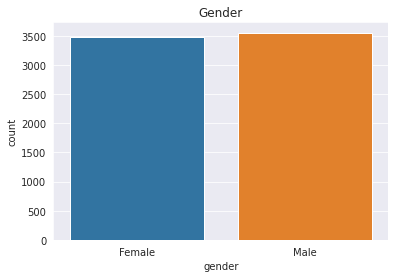

In [39]:
sns.set_style('darkgrid')
ax = sns.countplot(df['gender'])
ax.set_title('Gender') 

None

Распределение клиентов по гендеру примерно одинаковое

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


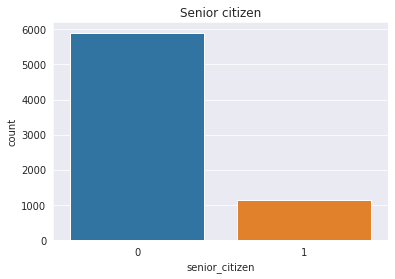

In [40]:
sns.set_style('darkgrid')
ax = sns.countplot(df['senior_citizen'])
ax.set_title('Senior citizen') 

None

Людей, вышедших на пенсию, примерно в 6 раз меньше

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


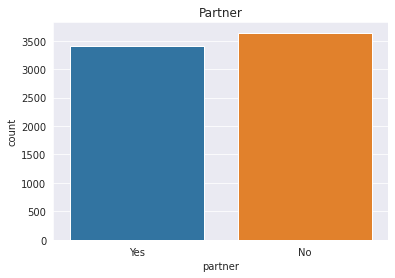

In [41]:
sns.set_style('darkgrid')
ax = sns.countplot(df['partner'])
ax.set_title('Partner') 

None

Также большая часть клиентов не имеют супруга или супруги

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


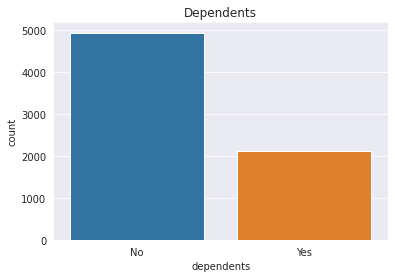

In [42]:
sns.set_style('darkgrid')
ax = sns.countplot(df['dependents'])
ax.set_title('Dependents') 

None

БОльшая часть клиентов не имеет иждевенцев

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


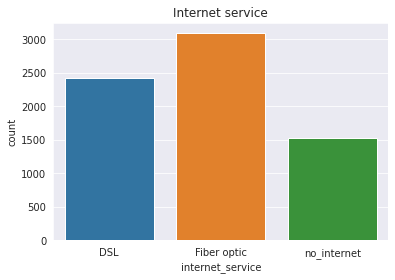

In [43]:
sns.set_style('darkgrid')
ax = sns.countplot(df['internet_service'])
ax.set_title('Internet service') 

None

Также большая часть клиентов пользуется оптоволоконным соединением, второе место DSL, третье -- люди, которые не пользуются интернетом

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


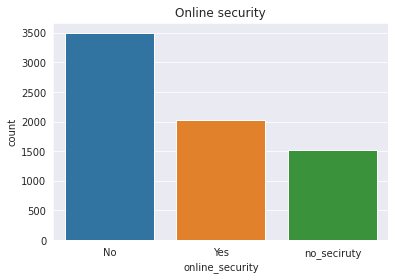

In [44]:
sns.set_style('darkgrid')
ax = sns.countplot(df['online_security'])
ax.set_title('Online security') 

None

Также 3500 человек не пользуются онлайн защитой

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


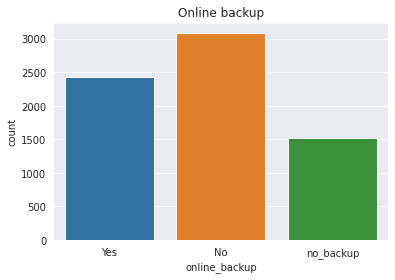

In [45]:
sns.set_style('darkgrid')
ax = sns.countplot(df['online_backup'])
ax.set_title('Online backup') 

None

И не создают резервных копий

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


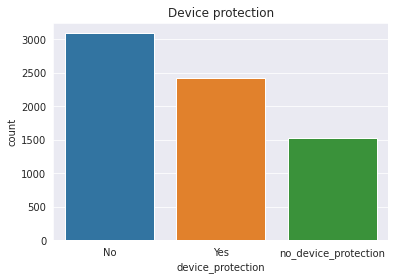

In [46]:
sns.set_style('darkgrid')
ax = sns.countplot(df['device_protection'])
ax.set_title('Device protection') 

None

Также чуть более 3000 клиентов не пользуются защитой устройств

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


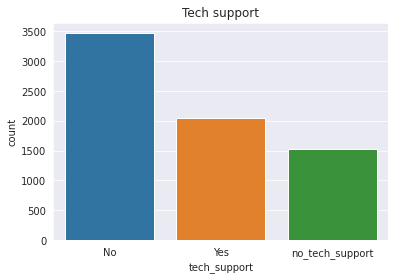

In [47]:
sns.set_style('darkgrid')
ax = sns.countplot(df['tech_support'])
ax.set_title('Tech support') 

None

Чаще всего люди не пользуются технической поддержкой

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


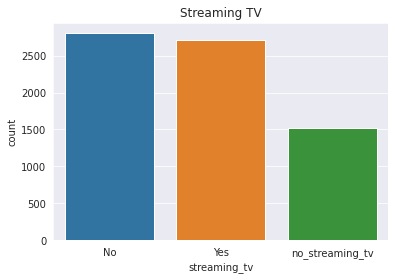

In [48]:
sns.set_style('darkgrid')
ax = sns.countplot(df['streaming_tv'])
ax.set_title('Streaming TV') 

None

Примерно одинаковое количество людей пользуются и не пользуются сервисом телевидения

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


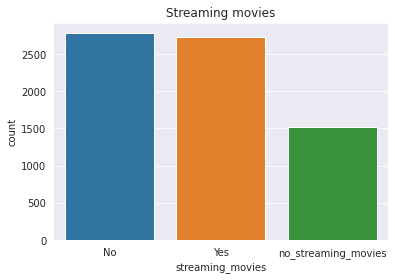

In [49]:
sns.set_style('darkgrid')
ax = sns.countplot(df['streaming_movies'])
ax.set_title('Streaming movies') 

None

И примерно такое же соотношение между людьми по параметру стриминга фильмов

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


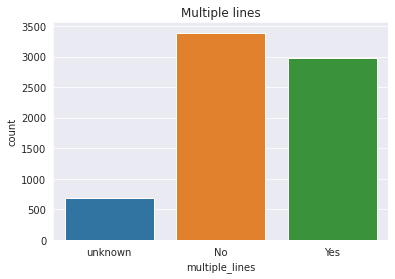

In [50]:
sns.set_style('darkgrid')
ax = sns.countplot(df['multiple_lines'])
ax.set_title('Multiple lines') 

None

Также и с переменной multiple lines: большее количество людей не пользуются такой услугой

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


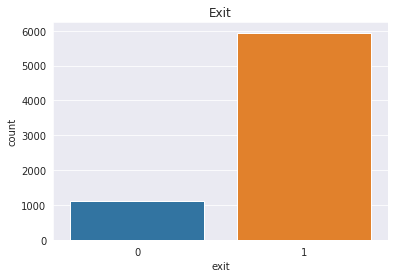

In [51]:
sns.set_style('darkgrid')
ax = sns.countplot(df['exit'])
ax.set_title('Exit') 

None

Анализ целевой переменной говорит о том, что примерно в 6 раз больше людей ушли на момент выгрузки датасета

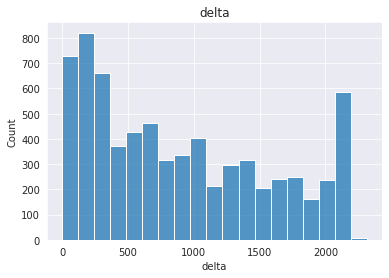

In [52]:
sns.set_style('darkgrid')
ax = sns.histplot(df['delta'])
ax.set_title('delta') 

None

Больше всего людей имеют контракт меньше года, однако виден всплеск на контрактах более 2000 дней примерно до 600

In [53]:
del df['begin_date'], df['end_date'], df['customer_id']

Удалим столбцы с датами для обучения моделей и удалим столбец customer_id

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'exit', 'delta']


<AxesSubplot:>

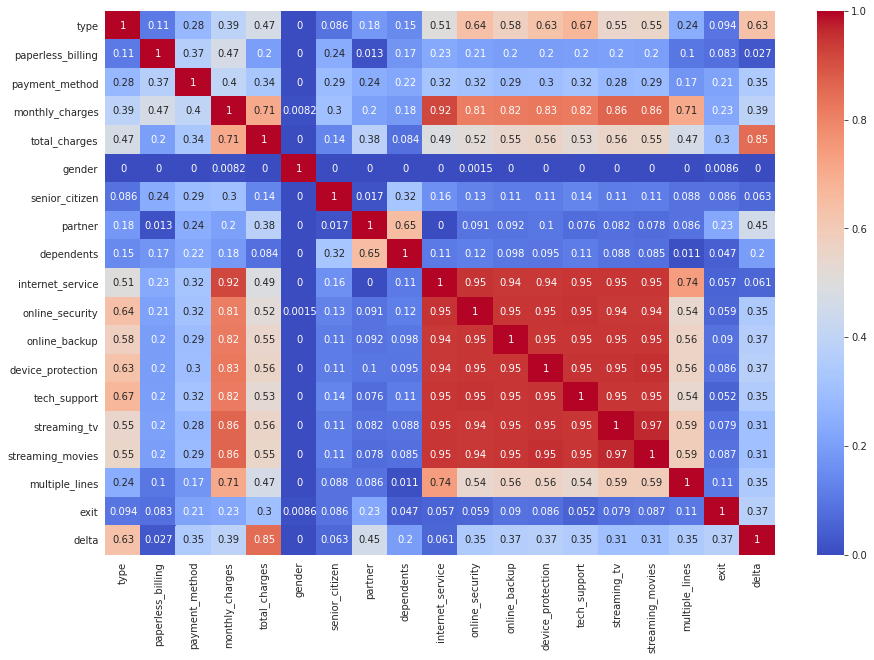

In [54]:
warnings.filterwarnings('ignore')

phik_overview = df.phik_matrix()

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(phik_overview, cmap='coolwarm', annot=True, ax=ax)

По матрице видно, что присутствует риск мультиколлинеарности, для того, чтобы избежать этого, удалим один количественных столбца из датафрейма:

In [55]:
del df['monthly_charges']

In [56]:
y = df['exit'] 
X = df.drop(columns=['exit'])

X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.25, random_state=RANDOM_STATE)

In [57]:
X_categirical = ['type', 'online_security', 'paperless_billing', 'payment_method', 'gender', 
                 'senior_citizen', 'partner', 'dependents', 'internet_service',
                 'online_backup', 'device_protection', 'tech_support',
                 'streaming_tv', 'streaming_movies', 'multiple_lines']

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_train[X_categirical])

def features_ohe(ohe_variable, df_features, features_categ):
    df_features_ohe = pd.DataFrame(
        data=ohe_variable.transform(df_features[features_categ]), 
        index=df_features.index,
        columns=ohe_variable.get_feature_names()
    )

    df_features = df_features.drop(features_categ, axis=1)
    df_features = df_features.join(df_features_ohe)
    return df_features    

X_train = features_ohe(ohe, X_train, X_categirical);
#X_valid = features_ohe(ohe, X_valid, X_categirical);
X_test = features_ohe(ohe, X_test, X_categirical);

In [58]:
warnings.filterwarnings('ignore')

num_cols = ['delta', 'total_charges']

scaler = StandardScaler()
scaler.fit(X_train[num_cols]) 

X_train[num_cols] = scaler.transform(X_train[num_cols])

X_test[num_cols] = scaler.transform(X_test[num_cols])

Используем standard scaler для точного обучения моделей

## Обучение логистической регрессии

Используем grid search cv для поиска оптимальных гиперпараметров

## Обучение CatBoostClassifier

In [60]:
%%time 

params = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.3],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

cat = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

grid = GridSearchCV(cat, params, cv=5, n_jobs=-1, verbose=False, scoring='roc_auc')

grid.fit(X_train, y_train) 

print(grid.best_score_)

0.9195477165339012
CPU times: user 15min 2s, sys: 28.4 s, total: 15min 30s
Wall time: 20min 24s


По значению метрики и по графику можно сделать вывод о том, что модель хорошо подходит для дальнейшего использования, но надо протестировать последнюю модель

## Обучение RandomForestClassifier

In [61]:
%%time

params = {
    'n_estimators': [100, 200, 500], 
    'max_depth': [5, 8, 15], 
    'min_samples_split': [2, 5, 10], 
    'max_features': ['auto', 'sqrt', 'log2']
}

rfc = RandomForestClassifier(random_state=RANDOM_STATE) 

cv = GridSearchCV(rfc, params, cv=5, n_jobs=-1, verbose=False, scoring='roc_auc')

cv.fit(X_train, y_train) 

print(cv.best_score_) 

0.8211202638718772
CPU times: user 5min 50s, sys: 2.08 s, total: 5min 52s
Wall time: 5min 52s


По выводу можно сказать, что последняя модель имеет результаты лучше, чем у логистической регрессии, однако примерно на 0,13 отстает от CatBoostClassifier. Таким образом после теста моделей можно сказать, что лучшая модель из рассмотренных -- CatBoostClassifier

## Тестирование лучшей модели

In [62]:
model = CatBoostClassifier(depth=4, l2_leaf_reg=1, 
                           learning_rate=0.1, 
                           random_state=RANDOM_STATE, verbose=0)
model.fit(X_train, y_train) 

final_pred = model.predict_proba(X_test)[:, 1]

final_roc = roc_auc_score(y_test, final_pred) 
print('Лучшая модель не тестовой выборке показывает результат:', final_roc)

Лучшая модель не тестовой выборке показывает результат: 0.9366210869370223


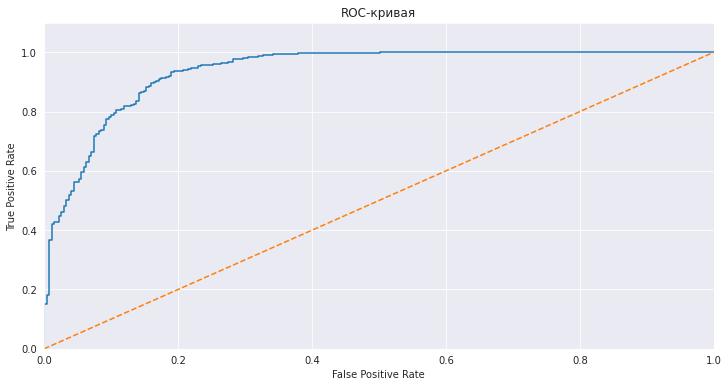

Целевая метрика: 0.9366210869370223


In [63]:
fpr, tpr, thresholds = roc_curve(y_test, final_pred)

plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('Целевая метрика:', final_roc)

## Важность признаков

In [64]:
X_importance = pd.DataFrame(model.feature_importances_, index=X_test.columns)

X_importance

,0
total_charges,14.648159
delta,56.849244
x0_One year,1.631332
x0_Two year,3.373972
x1_Yes,1.117106
x1_no_seciruty,0.051121
x2_Yes,1.458951
x3_Credit card (automatic),1.156118
x3_Electronic check,1.404284
x3_Mailed check,1.629722


## Построение матрицы ошибок по лучшей модели

AxesSubplot(0.125,0.125;0.62x0.755)
[[ 180   89]
 [  15 1477]]


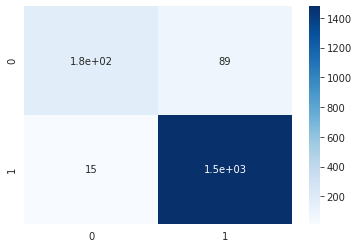

In [65]:
y_pred = model.predict(X_test)

cm = sns.heatmap(confusion_matrix(y_test, y_pred), cmap='Blues', annot=True)

print(cm)
print(confusion_matrix(y_test, y_pred))

По матрице ошибок можно сделать следующие выводы: 


- 180 верных предсказаний для класса 0 
- 1477 верных предсказаний для класса 1
- 89 объектов класса 0 были неверно отнесены к классу 1
- 15 объектов класса 1 были неверно отнесены к классу 0 
  
Таким образом можно сказать, что модель лучше предсказывает класс 1, т.к. для него меньше ошибок, для класса 0 есть несколько "ложных срабатываний".

## Выводы

В проекте были выполнены основные главы предобработки и анализа данных: 
    
- Переименованы столбцы
- Проведен анализ дисбаланса классов
- Добавлен новый признак

    
После этого данные были подготовлены для дальнейшего использования в моделях машинного обучения: 
- Заполнены пропуски
- Данные изучены на риск мультиколлинеарности
- Удалены столбцы, которые могут помешать обучению моделей
- Проведена кодировка данных
- Данные были разбиты на выборки

Последним этапом стал тест моделей: 
    
- Для каждой модели были подобраны гиперпараметры и использованием GridSearchCV
- Для каждой модели был построен график ROC-AUC и посчитана метрика
- Выбрана лучшая модель (CatBoostRegressor) для которой метрика ROC-AUC составила 0.93
- Построена матрица ошибок для лучшей модели
    
    
Таким образом удалось получить модель, которая прогнозирует уйдет клиент или нет с точностью 0.93.

# Итоговый отчет

    
<b> Описание проекта </b>
    
Финальный проект посвящен теме оттока клиентов из компании "ниединогоразрыва.ком". В рамках проекта была поставлена задача решения задачи бинарной классификации пользователей, которые хотят перестать использовать услуги компании. В случае, если человек планирует уйти, ему будут предложены дополнительные сертификаты и промокоды, чтобы минимизировать отток клиентов из компании. Таким образом будущая целевая переменная будет принимать вид 0 или 1, где 0 -- клиент не отказался от услуг, а 1 -- отказался. 
    
---
    
<b> План работы </b>
    
Для работы над проектом был создан подробный план, предусматривающий все этапы работы, которые предстояло выполнить. Проанализировав 4 датафрейма с исходными данными они были объединены в один для удобства проводимого анализа и наглядной визуализации представляемого материала. 
    
--- 
 
<b> Описание данных </b>  
    
В 4 исходных датафреймах были представлены следующие данные: 
    
- Begin Date -- Дата, когда клиент подписал договор с компанией и начал пользоваться услугами. 
- End Date -- Дата, когда клиент перестал пользоваться услугами компании. 

<i> В df эта переменная была изменена и вместо 'No', что означает, что клиент еще пользуется услугами, была подставлена дата выгрузки датасетов </i>

- Type -- Тип оплаты контракта о предоставлении услуг
- Paperless Billing -- Электронный чек о транзакции компании 
- Payment Method -- Способ оплаты услуг
- Monthly Charges -- Ежемесячные траты клиентов на услуги
- Total Charges -- Сколько всего клиенты потратили денег на услуги за время действия контракта
- Dependents -- Есть ли иждивенцы у клиента
- Senior Citizen -- Достиг ли клиент пенсионного возраста
- Partner -- Есть ли у клиента супруг или супруга
- Multiple Lines -- Подключил ли клиент возможность ведения параллельных линий при звонке
- Internet Service -- Пользуется ли клиент интернет услугами
- Online Security -- Пользуется ли клиент услугами "защиты" в интернете
- Online Backup -- Создаются ли для клиента резервные копии данных
- Device Protection -- Пользуется ли клиент защитой устройства
- Tech Support -- Пользуется ли клиент технической поддержкой
- Streaming TV -- Пользуется ли клиент услугами телевидения
- Streaming Movies -- Пользуется ли клиент услугами стриминга фильмов
    
Также в df были добавлены два новых признака: 
    
- Delta -- Показывает сколько дней длится контракт клиента, или сколько дней длился контракт клиента, если он был расторгнут до даты выгрузки датасета.
- Exit -- Целевая переменная, которая впоследствии вошла в target (y)
    
Практически все эти данные вошли в матрицу признаков для дальнейшего обучения модели, кроме временных признаков (Begin Date, End Date), также были удалены признаки Customer ID, потому что такой признак может негативно повлиять на обучение моделей и Monthly Charges, для того, чтобы минимизировать риск мультиколлинеарности по количественным переменным.
    
---    
    
<b> Предобработка данных </b>  

После объединения в общем датафрейме (df) возникли пропуски, потому что определенное количество людей не пользуются услугами интернета или не подключают несколько телефонных линий и т.д. Такие пропуски были заполнены заглушками для более качественного обучения моделей, однако негативно повлияли на риск мультиколлинеарности, поскольку по корреляции &phi;&kappa; признаки, в которых пропуски были заполнены заглушками начали сильно коррелировать (~0.95), но впоследствии после получения результатов обучения это не повлияло на финальный этап разработки и позволило достичь нужной планки по целевой метрике AUC ROC. 
    
---
    
<b> Подготовка данных для обучения моделей </b>
    
Данные были закодированы, используя One Hot Encoder из библиотеки sklearn, а также масштабированы, используя Standard Scaler с количественными переменными delta и Total Charges.
    
---
    
<b> Обучение моделей </b>
    
Для прогнозирования целевой переменной были использованы три модели: Logistic Regression, Cat Boost Classifier, Random Forest Classifier. Для каждой модели были подобраны гиперпараметры, используя GridSearchCV, а также получены результаты обучения и прогнозов на тренировочной выборке: 

- AUC ROC Logistic Regression -- <b> 0.7590 </b>
- AUC ROC Cat Boost Classifier -- <b> 0.9195 </b>
- AUC ROC Random Forest Classifier -- <b> 0.8211 </b>
    
Таким образом можно сказать, что на тренировочной выборке после кросс-валидации лучше всего себя показала модель Сat Boost Classifier с гиперпараметрами: 
    
- <b> depth = 4 </b>
- <b> l2_leaf_reg = 1 </b>
- <b> learning_rate = 0.1 </b>
- <b> random_state = RANDOM_STATE (const) = 140823 </b>
    
---
    
<b> Тестирование лучшей модели на тестовой выборке </b>
    
На тестовой выборке модель Сat Boost Classifier показала результат 0.9366, что показывает, что модель хорошо справляется с поставленной задачей и имеет хороший резузьтат по метрике AUC ROC. CBC по матрице ошибок получила следующие результаты: 

- 180 верных предсказаний для класса 0 
- 1477 верных предсказаний для класса 1
- 89 объектов класса 0 были неверно отнесены к классу 1
- 15 объектов класса 1 были неверно отнесены к классу 0 